In [1]:
import pandas as pd
import numpy as np
from generate_data import preprocess

data = pd.read_csv("data/de_matrix.tsv", sep="\t")
design = pd.read_csv("data/de_design_matrix.tsv", sep="\t")
data, design = preprocess(data, design)

/Users/erikhartman/dev/peptide-flyability/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/erikhartman/dev/peptide-flyability/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/erikhartman/dev/peptide-flyability/.venv/lib/python3.9/site-packages/numba/core/decorators.py:250: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [2]:
from generate_data import generate_pair_matrix

X_spike, y_spike = generate_pair_matrix(data, design)
y_spike

AAS_P2009_167_sp|P99027|RLA2_MOUSE_LASVPAGGAVAVSAAPGSAAPAAGSAPAAAEEKKDEK_LASVPAGGAVAVSAAPGSAAPAAGSAPAAAEEKK        1.061100
AAS_P2009_167_sp|P99027|RLA2_MOUSE_LASVPAGGAVAVSAAPGSAAPAAGSAPAAAEEKKDEK_ILDSVGIEADDDRLNK                          0.880753
AAS_P2009_167_sp|P99027|RLA2_MOUSE_LASVPAGGAVAVSAAPGSAAPAAGSAPAAAEEKKDEK_ILDSVGIEADDDR                             0.993691
AAS_P2009_167_sp|P99027|RLA2_MOUSE_LASVPAGGAVAVSAAPGSAAPAAGSAPAAAEEKKDEK_LASVPAGGAVAVSAAPGSAAPAAGSAPAAAEEK         0.877632
AAS_P2009_167_sp|P99027|RLA2_MOUSE_LASVPAGGAVAVSAAPGSAAPAAGSAPAAAEEKKDEK_NIEDVIAQGVGK                              0.869384
                                                                                                                     ...   
AAS_P2009_167_sp|Q61703|ITIH2_MOUSE_FLHVPDTFEGHFQGVPVISK_LVNNSPLPQSVVFDVQIPK                                       1.085118
AAS_P2009_167_sp|Q9QYR9|ACOT2_MOUSE_AHAVAQVDAWQQLQTFFHK_DVQTPFLVELEVLDGHEPDGGQR                                    1.003454
AAS_P200

In [3]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaled_X = scaler.fit_transform(X_spike)

X_spike = pd.DataFrame(scaled_X, index=X_spike.index, columns=X_spike.columns)
X_spike.shape

(16777, 50)

In [4]:
from xgboost import XGBRegressor

reg = XGBRegressor()
reg.fit(X_spike, y_spike.values)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

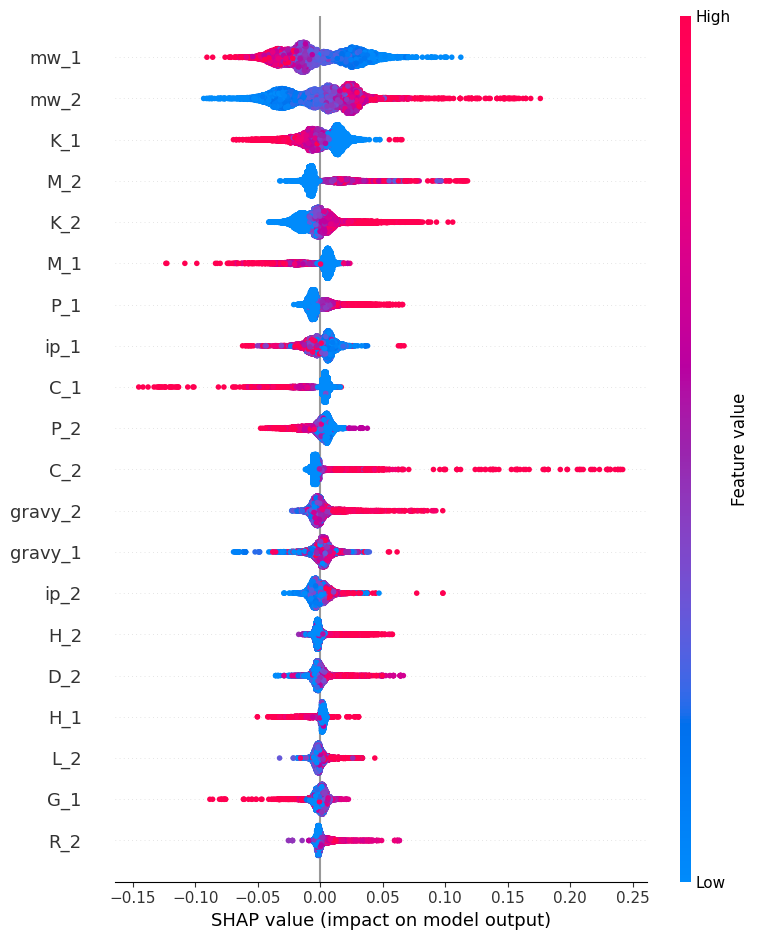

In [5]:
import shap

explainer = shap.TreeExplainer(reg)
explanation = explainer(X_spike)

shap.summary_plot(explanation)

In [6]:
data_sepsis = pd.read_csv("data/data_sepsis.tsv", sep="\t")
design_sepsis = pd.read_csv("data/design_sepsis.tsv", sep="\t")
data_sepsis, design_sepsis = preprocess(data_sepsis, design_sepsis)

X_sepsis, y_sepsis = generate_pair_matrix(data_sepsis, design_sepsis)

X_all = pd.concat([X_sepsis, X_spike])
y_all = pd.concat([y_sepsis, y_spike])

scaler = StandardScaler()

scaled_X = scaler.fit_transform(X_all)

X_all = pd.DataFrame(X_all, index=X_all.index, columns=X_all.columns)

print(X_all.shape)

reg = XGBRegressor()
reg.fit(X_all, y_all.values)

(59179, 50)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

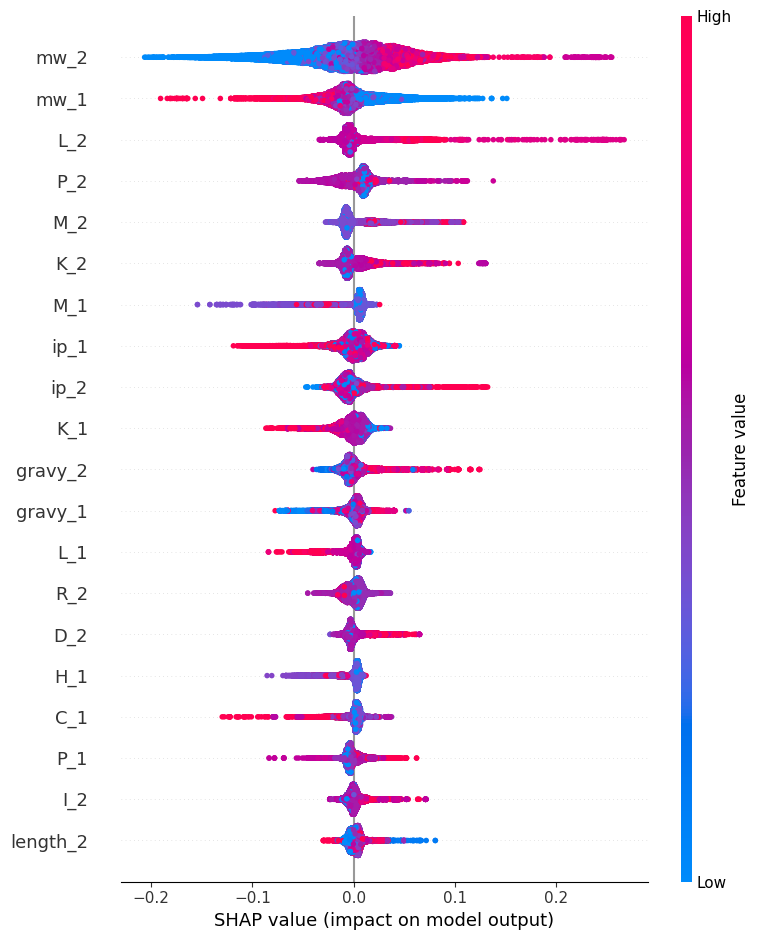

In [7]:
explainer = shap.TreeExplainer(reg)
explanation = explainer(X_all)

shap.summary_plot(explanation)

<Axes: ylabel='Count'>

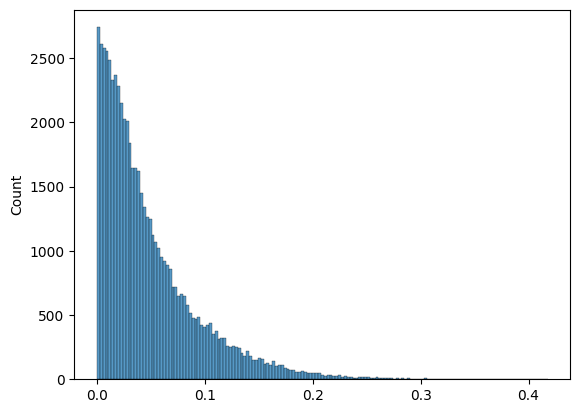

In [35]:
import seaborn as sns

error = np.abs(reg.predict(X_all) - y_all)
sns.histplot(error)